# Calibration of Images from Different Cameras
Use a checkerboard pattern to calibrate images from different cameras. The calibration process will allow you to undistort the images and obtain the camera matrix and distortion coefficients. This notebook is based on the OpenCV tutorial [Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import spectral.io.envi as envi
import glob

# Load hrHSI

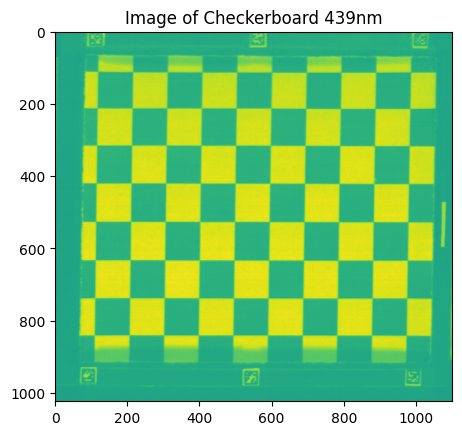

In [73]:
# Loading function
def LoadHSI(path_to_hdf5, return_wlens = False, print_info = False):

    # Open the HDF5 file
    with h5py.File(path_to_hdf5, 'r') as f:
        if print_info:

            # List the names of all datasets in the file
            print("Datasets in the file:")

            for name in f.keys():
                print(name)

                # List the attributes of the dataset
                data = f[name]
                print("Attributes of the dataset:")

                for key in data.attrs.keys():
                    print(f"{key}: {data.attrs[key]}")


        # get the dataset from the file (this is how we save the objects downstairs)
        dataset = f['hypercube']
        hcube = f['hypercube'][:]

        if not return_wlens:
            return hcube
        else:
            return hcube, np.array(dataset.attrs['wavelength_nm'])

hr_path = "data/FX10/"
hr_name = "calibration3"
hr_file = LoadHSI(hr_path + hr_name + ".hdf5", return_wlens=True, print_info=False)

# Load hypercube
hr_img = hr_file[0]

# Normalize hypercube
hr_img = hr_img / np.max(hr_img)

# Flip hypercube to align with snapshot
hr_img = np.flip(hr_img, axis=1)
hr_img = np.flip(hr_img, axis=2)

# Rearrange hypercube to be in the shape of (x, y, wavelength)
hr_img = np.moveaxis(hr_img, 0, -1)

# Load wavelengths as integers
hr_wavelengths = hr_file[1].astype(int)
hr_wavelengths = hr_wavelengths.tolist()

# Display 2D image
hr_selected_spectrum = 16

# Print array as image
plt.figure()
plt.imshow(hr_img[:, :, hr_selected_spectrum])
plt.title('Image of Checkerboard ' + str(hr_wavelengths[hr_selected_spectrum]) + 'nm')
plt.show()

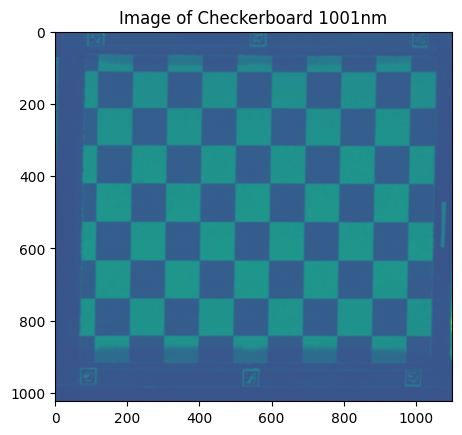

In [74]:
# Display 2D image
hr_selected_spectrum = 223

# Print array as image
plt.figure()
plt.imshow(hr_img[:, :, hr_selected_spectrum])
plt.title('Image of Checkerboard ' + str(hr_wavelengths[hr_selected_spectrum]) + 'nm')
plt.show()

In [75]:
# Store 2d image as cv image
import cv2 as cv
cv.imwrite('data/FX10/2D/' + hr_name + ".jpg", hr_img[:, :, hr_selected_spectrum] * 255)

True

## hrHSI Checkerboard

In [76]:
# Set grid size
grid_x = 8
grid_y = 6

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((grid_y*grid_x, 3), np.float32)
objp[:,:2] = np.mgrid[0:grid_x, 0:grid_y].T.reshape(-1,2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
 
images = glob.glob('data/FX10/2D/*.jpg')

 
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (grid_x, grid_y), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (grid_x, grid_y), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(2000)
    else:
        print("No corners found in image: " + fname)
 
cv.destroyAllWindows()

No corners found in image: data/FX10/2D\checker00.jpg
No corners found in image: data/FX10/2D\checker01.jpg
No corners found in image: data/FX10/2D\checker02.jpg
No corners found in image: data/FX10/2D\checker03.jpg


In [77]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save the camera matrix and distortion coefficients
np.save('data/FX10/2D/hrHSI_matrix', mtx)
np.save('data/FX10/2D/hrHSI_dist', dist)

### Undistort

In [81]:
# Select image to undistort
hr_name = "calibration3"

# Read 2d image
img = cv.imread('data/FX10/2D/' + hr_name + '.jpg', cv.IMREAD_GRAYSCALE)
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

 
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('data/FX10/2D/undist_' + hr_name + '.png', dst)

True

# Load Snapshot

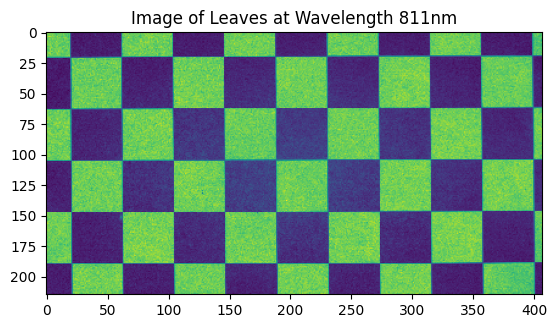

In [19]:
ss_path = "data/Snapshot/new_calibration_processed/"
ss_name = "new_calibration"
ss_num = 0

# Open image
ss_file = envi.open(ss_path + ss_name + str(ss_num) + "/image_000000000" + str(ss_num) + ".hdr", 
                    ss_path + ss_name + str(ss_num) + "/image_000000000" + str(ss_num) + ".raw")

# Load as ImageArray
ss_img = ss_file.load()

# Load as numpy array
ss_img_np = np.array(ss_file.load())

# Normalize image
ss_img_np = ss_img_np / np.max(ss_img_np)

# Load wavelengths
ss_wavelengths = ss_file.metadata['wavelength']
ss_wavelengths = [float(wavelength) for wavelength in ss_wavelengths]

# Turn float to int
ss_wavelengths = [int(wavelength) for wavelength in ss_wavelengths]

# Select a pixel on a leaf
ss_selected_spectrum = 12

# Print array as image
plt.figure()
plt.imshow(ss_img_np[:, :, ss_selected_spectrum])
plt.title('Image of Leaves at Wavelength ' + str(ss_wavelengths[ss_selected_spectrum]) + 'nm')
plt.show()

In [20]:
import cv2 as cv
import glob

# cv.imwrite("data/Snapshot/2D/calib.jpg", ss_img_np[:, :, ss_selected_spectrum])
cv.imwrite('data/Snapshot/2D/' + ss_name + str(ss_num) + ".jpg", ss_img[:, :, ss_selected_spectrum] * 255)

True

## Snapshot Checkerboard

In [27]:
# Set grid size
grid_x = 9
grid_y = 5

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((grid_y*grid_x, 3), np.float32)
objp[:,:2] = np.mgrid[0:grid_x, 0:grid_y].T.reshape(-1,2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
 
# images = glob.glob('data/Snapshot/2D/*.jpg')
images = glob.glob("data/Snapshot/2D/new_calibration0.jpg")
 
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (grid_x, grid_y), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (grid_x, grid_y), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(3000)
    else:
        print("No corners found in image: " + fname)
 
cv.destroyAllWindows()

In [28]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save the camera matrix and distortion coefficients
np.save('data/Snapshot/2D/snapshot_matrix', mtx)
np.save('data/Snapshot/2D/snapshot_dist', dist)

### Undistort Snapshot

In [30]:
# Select image to undistort
ss_name = "new_calibration"
ss_num = 0

# Read 2d image
img = cv.imread('data/Snapshot/2D/' + ss_name + str(ss_num) + '.jpg', cv.IMREAD_GRAYSCALE)
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

 
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('data/Snapshot/2D/undist_' + ss_name + str(ss_num) + '.jpg', dst)

True

# Undistort Full HSI

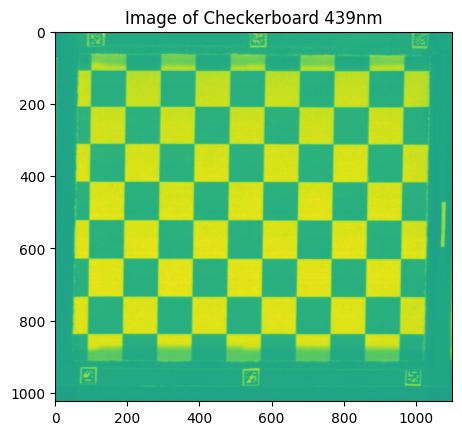

In [31]:
# Load full hrHSI
# Loading function
def LoadHSI(path_to_hdf5, return_wlens = False, print_info = False):

    # Open the HDF5 file
    with h5py.File(path_to_hdf5, 'r') as f:
        if print_info:

            # List the names of all datasets in the file
            print("Datasets in the file:")

            for name in f.keys():
                print(name)

                # List the attributes of the dataset
                data = f[name]
                print("Attributes of the dataset:")

                for key in data.attrs.keys():
                    print(f"{key}: {data.attrs[key]}")


        # get the dataset from the file (this is how we save the objects downstairs)
        dataset = f['hypercube']
        hcube = f['hypercube'][:]

        if not return_wlens:
            return hcube
        else:
            return hcube, np.array(dataset.attrs['wavelength_nm'])

hr_path = "data/FX10/"
hr_name = "calibration0"
hr_file = LoadHSI(hr_path + hr_name + ".hdf5", return_wlens=True, print_info=False)

# Load hypercube
hr_img = hr_file[0]

# Normalize hypercube
hr_img = hr_img / np.max(hr_img)

# Flip hypercube to align with snapshot
hr_img = np.flip(hr_img, axis=1)
hr_img = np.flip(hr_img, axis=2)

# Rearrange hypercube to be in the shape of (x, y, wavelength)
hr_img = np.moveaxis(hr_img, 0, -1)

# Load wavelengths as integers
hr_wavelengths = hr_file[1].astype(int)
hr_wavelengths = hr_wavelengths.tolist()

# Display 2D image
hr_selected_spectrum = 16

# Print array as image
plt.figure()
plt.imshow(hr_img[:, :, hr_selected_spectrum])
plt.title('Image of Checkerboard ' + str(hr_wavelengths[hr_selected_spectrum]) + 'nm')
plt.show()

In [ ]:
# Undistort image
import cv2 as cv

# Load camera matrix
mtx = np.load('data/FX10/2D/hrHSI_matrix.npy')
dist = np.load('data/FX10/2D/hrHSI_dist.npy')



# Read full HSI image
img = hr_img
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

 
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
# cv.imwrite('data/Snapshot/2D/undist_' + ss_name + str(ss_num) + '.jpg', dst)


In [ ]:
# Show undistorted image next to distorted image
plt.figure()
plt.subplot(121)
plt.imshow(hr_img[:, :, hr_selected_spectrum])
plt.title('Distorted Image')
plt.subplot(122)
plt.imshow(dst[:, :, hr_selected_spectrum])
plt.title('Undistorted Image')
plt.show()